In [ ]:
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from IPython.display import display, Markdown
from plotly.subplots import make_subplots
import textwrap
import os

# BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import openai
from bertopic.representation import OpenAI
from sklearn.metrics.pairwise import cosine_similarity

## **TABLE OF CONTENTS**:
- [HOW TO USE](#how_to_use)
- [DATASET](#dataset)
- [SEARCH DATASET](#search-dataset)
- [PARAMETERS BERTOPIC](#parameters)
- [LOAD DATA](#load-data)
- [EXECUTE BERT](#execute-bert)
- [ANALYZE CLUSTERS](#analyze-clusters)
  - [TOPIC BARCHART](#topic_barchart)
  - [TOPIC HIERARCHY](#topic_hierarchy)
  - [TOPIC DISTANCE MAP](#topic_distance)
- [MERGE CLUSTERS INTO DATASET](#merge_clusters)
- [OUTLIERS](#outliers)
- [TRANSFORM QUERY AND ASSIGN CLOSEST CLUSTER](#query_assign)
  - [ASSIGNED TOPICS WORDCLOUD](#topic_worldcloud)
- [VIZUALIZATIONS FOR ONE SPECIFIC TOPIC](#visual_one)
  - [PROJECTS IN TOPIC](#projects_topic)
  - [RELATED TOPICS](#topic_related)
- [VIZUALIZATIONS FOR MULTIPLE TOPICS](#visual_multiple)
  - [PROJECT COUNT OVER TIME](#project_count)
  - [SUB-DEPARTMENTS](#sub_departments)
  - [FUNDING SCHEMES](#funding)
  - [FUNDING SCHEMES IN DEPTH](#funding_whole)
- [DEEP DIVE INTO TOPIC](#deep_dive)
- [SOURCES](#sources)

## **HOW TO USE** <a class="anchor" id="how_to_use"></a>
1. Select dataset, it should be cleaned with the provided code in the data_preprocessing folder.
2. Input a query, from your query topics will be assigned. Similarity will be calculated between your query and each topic representation, from this the top $n$ topics will be selected.
3. Set parametes for BERTopic. Note: some visualizations have also paramters, those can be changed at the specific visualizations. To easily find these parameters, they will be marked with <font color='red'>**PARAMETER**</font>.
4. Run the whole notebook.
5. Use table of contents to get desired info. Note: Some visualizations allow you to change the topics you want to visualize, where this can be done will be marked with <font color='red'>**SELECT**</font><br>


## **DATASET** <a class="anchor" id="dataset"></a>

In [2]:
DATASET = "../data/rvo_df_eng.pkl" # dataset name / location
EXPORT_TOPICS = False # set to true if you want to export all topics
DF_TOPICS = "df_topics_info.csv" # set name for exported topics data (must be .csv)
EXPORT_TOPICS_MERGED = False # set to true if you want to export dataset with topics
DF_TOPICS_MERGED = "df_projects_merged_topics.csv" # set name for exported dataset with topics (must be .csv)

EXPORT_GRAPHS_CSV = True # set to true if you want to export all graphs data as csv files

## **SEARCH DATASET** <a class="anchor" id="search-dataset"></a>

In [3]:
# input your project query here, e.g. roman empire alexander the great greece
QUERY = ['sustainability industry innovation process technology innovation raw materials circularity consumption goods']

## **PARAMETERS BERTOPIC** <a class="anchor" id="parameters"></a>

Here are the parameters for BERTopic. We set them to the values that we believe are best.

In [4]:
# the model
LOAD_EMBEDDINGS = True  # set to True if embeddings are pre-saved
LOAD_MODEL = True  # set to True if a model is pre-saved
# the number of words per topic that you want to be extracted. These words are most representative of the topic.
N_WORDS_REPRESENTATION = 8
# the number of words you want in your topic representation. If you want 'Circular Economy' in your representations, set it to (1,2)
N_GRAM_RANGE = (1, 2)
# the minimum size of a topic. Lower means more topics, higher means less topics.
MIN_TOPIC_SIZE = 8

# assigning topics
TOPIC_COUNT = 8  # number of topics to identify; higher values will reduce accuracy
MIN_PROJECTS_CLUSTER = 0 # set higher to filter out topics with few projects

## **LOAD DATA** <a class="anchor" id="load-data"></a>

In [5]:
df_projects = pd.read_pickle(DATASET)

In [6]:
# nicer dataframe displays
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None) 
pd.set_option('display.max_colwidth', 50)

print(df_projects.shape)
display(df_projects.head(1))

(707, 14)


,Subsidie categorie,TKI/Thema,Innovatiethema('s),Subsidieregeling,Projectnummer,Looptijd,Subsidiebedrag,Penvoerder,Projectconsortium,Projecttitel,Publieke samenvatting,Website link,text,language
0,Versnelde klimaatinvesteringen industrie (VEKI),Directe effecten aan de schoorsteen (scope 1),Energie-efficiency,VEKI-23-01-01-Klimaatinvest. Indus.,VEKI523010,01-07-2023 - 31-12-2025,1549579.0,Kingspan Insulation B.V.,Kingspan Insulation B.V.,electricaldriven drying ovens,aanleiding currently the kingspans kooltherm i...,https://projecten.topsectorenergie.nl/projecte...,electricaldriven drying ovens aanleiding curre...,en


In [7]:
COLUMN_FUNDING_SCHEME = 'Subsidie categorie'
COLUMN_PROJECT_ID = 'Projectnummer'

## **EXECUTE BERT** <a class="anchor" id="execute-bert"></a>

In [8]:
# GPT 3.5
prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
topic: <topic label>
"""

client = openai.OpenAI()
openai_model = OpenAI(client, model="gpt-3.5-turbo-0125", exponential_backoff=True, chat=True, prompt=prompt)

representation_model = {
    "OpenAI": openai_model
}

In [9]:
docs = list(df_projects.text.values) # create stacked list of abstracts

if LOAD_EMBEDDINGS:
    # load embeddings
    sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = np.load('embeddings/rvo/embeddings.npy')
else:
    # pre-embed abstracts
    sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = sentence_model.encode(docs, show_progress_bar=True)
    
    # save embeddings
    save_dir = 'embeddings/rvo/'
    os.makedirs(save_dir, exist_ok=True)
    np.save(os.path.join(save_dir, 'embeddings.npy'), embeddings)

In [10]:
if LOAD_MODEL:
    # load the BERTopic model
    topic_model = BERTopic.load("models/rvo/BERTopic")

    # use the transform method to obtain topics and probabilities for the new documents
    topics, probs = topic_model.transform(docs, embeddings)
else:
    vectorizer_model = CountVectorizer(stop_words="english")    

    topic_model = BERTopic(verbose=True, 
                        calculate_probabilities=True,
                        top_n_words=N_WORDS_REPRESENTATION,
                        n_gram_range=N_GRAM_RANGE,
                        min_topic_size=MIN_TOPIC_SIZE,
                        vectorizer_model=vectorizer_model,
                        representation_model=representation_model,
                        embedding_model=sentence_model)

    topics, probs = topic_model.fit_transform(docs, embeddings)
    
    # save the model
    save_dir = 'models/rvo/'
    os.makedirs(save_dir, exist_ok=True)
    embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
    topic_model.save(os.path.join(save_dir, "BERTopic"), serialization="safetensors", save_embedding_model=embedding_model)

2024-06-29 09:32:00,811 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


In [11]:
# add chatgpt labels to the model
chatgpt_topic_labels = {topic: " | ".join(list(zip(*values))[0]) for topic, values in topic_model.topic_aspects_["OpenAI"].items()}
chatgpt_topic_labels[-1] = "Outlier Topic"
topic_model.set_topic_labels(chatgpt_topic_labels)

topic_model.get_topic_info().head(2)

,Topic,Count,Name,CustomName,Representation,OpenAI,Representative_Docs
0,-1,163,-1_process_project_production_energy,Outlier Topic,"[process, project, production, energy, new, in...",[Sustainable Energy Efficient Production],NaN
1,0,94,0_plastic_recycling_waste_plastics,Plastic Waste Recycling Solutions,"[plastic, recycling, waste, plastics, project,...",[Plastic Waste Recycling Solutions],NaN


## **ANALYZE CLUSTERS** <a class="anchor" id="analyze-clusters"></a>

In [12]:
# show most prominent topics
df_topic_info = topic_model.get_topic_info()
df_topic_info.head(2)

,Topic,Count,Name,CustomName,Representation,OpenAI,Representative_Docs
0,-1,163,-1_process_project_production_energy,Outlier Topic,"[process, project, production, energy, new, in...",[Sustainable Energy Efficient Production],NaN
1,0,94,0_plastic_recycling_waste_plastics,Plastic Waste Recycling Solutions,"[plastic, recycling, waste, plastics, project,...",[Plastic Waste Recycling Solutions],NaN


In [13]:
if EXPORT_TOPICS is True:
    df_topic_info.to_csv(DF_TOPICS, index=False)

**Topic -1 are outliers**

#### **TOPIC BARCHART** <a class="anchor" id="topic_barchart"></a>

In [14]:
topic_model.visualize_barchart(top_n_topics=8, n_words=10, custom_labels=True, width=400)

#### **TOPIC HIERARCHY** <a class="anchor" id="topic_hierarchy"></a>

This plot shows the cluster hierarchy. Since we use HDBSCAN as a clustering algorthim, this means that clusters within clusters can be formed. To understand how these are related to each other we can use the plot below. A color indicates clusters that are closer related to each other. These are then broken down to smaller clusters with more specific topics.

In [15]:
topic_model.visualize_hierarchy(custom_labels=True)

#### **TOPIC DISTANCE MAP** <a class="anchor" id="topic_distance"></a>

This graph shows the 2D representation of the clusters, where the y-axis is the first dimensionality and the x-axis the second dimensionality.

Use the slider to select a topic, which will then light up. Hovering over a topic will give the topic size and its label. If you hold and drag with your mouse pointer you can zoom into the map to analyze the cluster structure.

In [16]:
topic_model.visualize_topics(custom_labels=True)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## **MERGE CLUSTERS INTO DATASET** <a class="anchor" id="merge_clusters"></a>

In [17]:
df_projects = pd.read_pickle(DATASET)
df_projects = df_projects.copy()

In [18]:
df_projects['Topic'] = topics
df_projects.head(1)

,Subsidie categorie,TKI/Thema,Innovatiethema('s),Subsidieregeling,Projectnummer,Looptijd,Subsidiebedrag,Penvoerder,Projectconsortium,Projecttitel,Publieke samenvatting,Website link,text,language,Topic
0,Versnelde klimaatinvesteringen industrie (VEKI),Directe effecten aan de schoorsteen (scope 1),Energie-efficiency,VEKI-23-01-01-Klimaatinvest. Indus.,VEKI523010,01-07-2023 - 31-12-2025,1549579.0,Kingspan Insulation B.V.,Kingspan Insulation B.V.,electricaldriven drying ovens,aanleiding currently the kingspans kooltherm i...,https://projecten.topsectorenergie.nl/projecte...,electricaldriven drying ovens aanleiding curre...,en,6


In [19]:
df_projects['Topic'] = df_projects['Topic'].astype(int)

df_projects = pd.merge(df_projects, df_topic_info[['Topic', 'Representation', 'CustomName']], left_on='Topic', right_on='Topic', how='left')

In [20]:
df_projects.head(1)

,Subsidie categorie,TKI/Thema,Innovatiethema('s),Subsidieregeling,Projectnummer,Looptijd,Subsidiebedrag,Penvoerder,Projectconsortium,Projecttitel,Publieke samenvatting,Website link,text,language,Topic,Representation,CustomName
0,Versnelde klimaatinvesteringen industrie (VEKI),Directe effecten aan de schoorsteen (scope 1),Energie-efficiency,VEKI-23-01-01-Klimaatinvest. Indus.,VEKI523010,01-07-2023 - 31-12-2025,1549579.0,Kingspan Insulation B.V.,Kingspan Insulation B.V.,electricaldriven drying ovens,aanleiding currently the kingspans kooltherm i...,https://projecten.topsectorenergie.nl/projecte...,electricaldriven drying ovens aanleiding curre...,en,6,"[steel, tata, iron, carbon, production, pilot,...",Steel Production Pilot Project


In [21]:
if EXPORT_TOPICS_MERGED is True:
    df_projects.to_csv(DF_TOPICS_MERGED, index=False)

In [22]:
# functions to print in markdown
def print_markdown(md_string):
    display(Markdown(md_string))
    
def print_markdown_list(items):
    md_string = ""
    for item in items:
        md_string += f"- ##### {item}\n"
    display(Markdown(md_string))

## **OUTLIERS** <a class="anchor" id="outliers"></a>

Outliers are those projects which do not fall into a topic clusters; projects that lie to far away from any cluster and thus are 'outliers'.

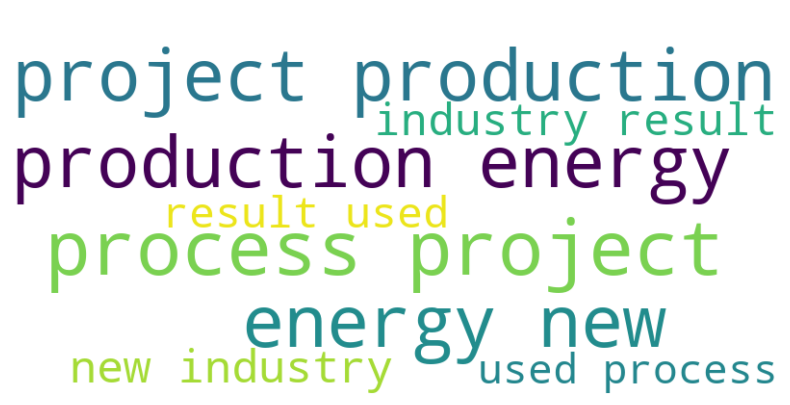

In [23]:
outlier_topic = df_projects[df_projects['Topic'] == -1]

words = ' '.join([' '.join(item) for item in outlier_topic['Representation']])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [24]:
SELECTED_TOPIC_ID = -1
TOPIC_INDEX = SELECTED_TOPIC_ID + 1
SELECTED_TOPIC_NAME = topic_model.get_topic_info()['CustomName'][TOPIC_INDEX]

topic_name = topic_model.get_topic_info()['CustomName'][TOPIC_INDEX]
print_markdown(f'### This table shows the likelihood that projects belong to Topic ({SELECTED_TOPIC_ID}) {SELECTED_TOPIC_NAME}:')

# extract the probabilities for the specific topic
if LOAD_MODEL:
    specific_topic_probs = probs[:, TOPIC_INDEX]
else:
    specific_topic_probs = probs[:, SELECTED_TOPIC_ID]

# find documents with a probability above the threshold
doc_indices = np.where(specific_topic_probs >= 0.3)[0]

docs_with_specific_topic = [docs[i] for i in doc_indices]

df_specific_topic = pd.DataFrame({
    'document': docs_with_specific_topic,
    'probability': specific_topic_probs[doc_indices]
})

# sort the dataframe in descending order
df_specific_topic = df_specific_topic.sort_values(by='probability', ascending=False).reset_index(drop=True)

df_specific_topic['probability'] = df_specific_topic['probability'].round(2)

# nicer dataframe displays
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None) 
pd.set_option('display.max_colwidth', 500)

display(df_specific_topic.head(5))

# new dataframe with only the top 10
df_specific_topic_top_n = df_specific_topic.head(10)

# truncate documents to threshold
df_specific_topic_top_n['document'] = df_specific_topic_top_n['document'].str.slice(0, 140)

fig = go.Figure(data=[
    go.Bar(
        y=df_specific_topic_top_n.index,
        x=df_specific_topic_top_n['probability'],
        text=df_specific_topic_top_n['document'],
        textposition='inside',
        insidetextanchor='end',
        orientation='h',
        marker_color='skyblue'
    )
])

fig.update_layout(
    title_text=f'Projects sorted on probability for Topic {SELECTED_TOPIC_ID} ({SELECTED_TOPIC_NAME})',
    xaxis_title=f'Probability of matching to topic {SELECTED_TOPIC_ID}',
    yaxis_title='Projects',
    yaxis_autorange="reversed"
)

fig.show()

### This table shows the likelihood that projects belong to Topic (-1) Outlier Topic:

,document,probability
0,geleen plasticplastic recycling aanleiding plastic energy bv has developed a novel thermal anaerobic conversion tac technology to recycle end of life eol plastic waste into tacoil a hydrocarbon that can be used to produce virgin plastic products plastic energy wants to demonstrate this technology in a new processing plant to be developed and constructed in geleen the netherlands plastic energy has experience with two other plants currently in operation using similar technology but on a small...,0.79
1,downstream isolation of highvalue components aanleiding the co footprint of the downstream separation technologies at frieslandcampina corbion biota shell and recell group can be significantly lowered by using innovative technologies current production trains at these endusers produce a lot of material waste and use a lot of solvents including water which then must be purified or recovered these purification and recovery steps in turn also use a lot of energy and materials the motivation of ...,0.79
2,sustainable softening line for nonferrous metal concentrate the applicant for the project is gebr van hemert brakel ii bv vhb group this company is specialized in the processing of aecbottom ash subsidiary aerinnova bv the operator within the project focuses specifically on the sorting and processing of nonferrous metal concentrate that comes from the bottom ash the current processing plant in brakel can no longer meet the desired capacity which is why aerinnova wants to open a new location ...,0.76
3,converting wastewater into composites reason the netherlands strives for a circular society in such a society waste flows must be reused and reprocessed as efficiently as possible this also applies to waste flows from wastewater treatment plants two important waste flows from water treatment are biopolymers indicated by the abbreviation ale potential size tons years and cellulose potential volume tons per year these flows are currently being fermented or incinerated however higherquality app...,0.76
4,altruistic innovative co reduction of atmospheric co to co storage in a carpet tile the netherlands emitted billion kg of co in this was billion kg of co the top shareholders consisted of the energy transport and industry industries with respectively billion billion and billion kg of co the share of the manufacturing industry has produced billion kg of co since interface products with reduced co footprints in the coming years the aim is to develop carpet products that store carbon to ensure ...,0.76


## **TRANSFORM QUERY AND ASSIGN CLOSEST CLUSTER** <a class="anchor" id="query_assign"></a>

These are the topics related to your query. Your query is firstly embedded, and then used to calculate the cosine similarity with each topic representation. The top $n$ topics are then shown. The number of topics shown can be changed at the top of the notebook.

In [25]:
print_markdown(f"### Input query:\n##### {QUERY[0]}")

similar_topics, similarity = topic_model.find_topics(QUERY[0], top_n=TOPIC_COUNT)
print_markdown(f"### Topics found (numbers):\n##### {similar_topics}\n")
TOPICS = [topic for topic in similar_topics if len(df_projects[df_projects['Topic'] == topic]) >= MIN_PROJECTS_CLUSTER]

print_markdown("### Topics, ranked top to bottom, match with query:\n")
topics_list = []
for i in TOPICS:
    if i >= 0:
        topic_projects = df_projects[df_projects['Topic'] == i]
        if not topic_projects.empty:
            topics_list.append(f"({i}): {topic_projects['CustomName'].iloc[0]}")

print_markdown_list(topics_list)

### Input query:
##### sustainability industry innovation process technology innovation raw materials circularity consumption goods

### Topics found (numbers):
##### [0, 15, 12, 10, 8, -1, 11, 6]


### Topics, ranked top to bottom, match with query:


- ##### (0): Plastic Waste Recycling Solutions
- ##### (15): Innovation Roadmap for SME Efficiency
- ##### (12): Tire Recycling Innovations
- ##### (10): Circular Foam Materials Development
- ##### (8): Concrete Recycling Innovations
- ##### (11): Sustainable Bioaromatics Coatings
- ##### (6): Steel Production Pilot Project


#### **ASSIGNED TOPICS WORDCLOUD** <a class="anchor" id="topic_worldcloud"></a>

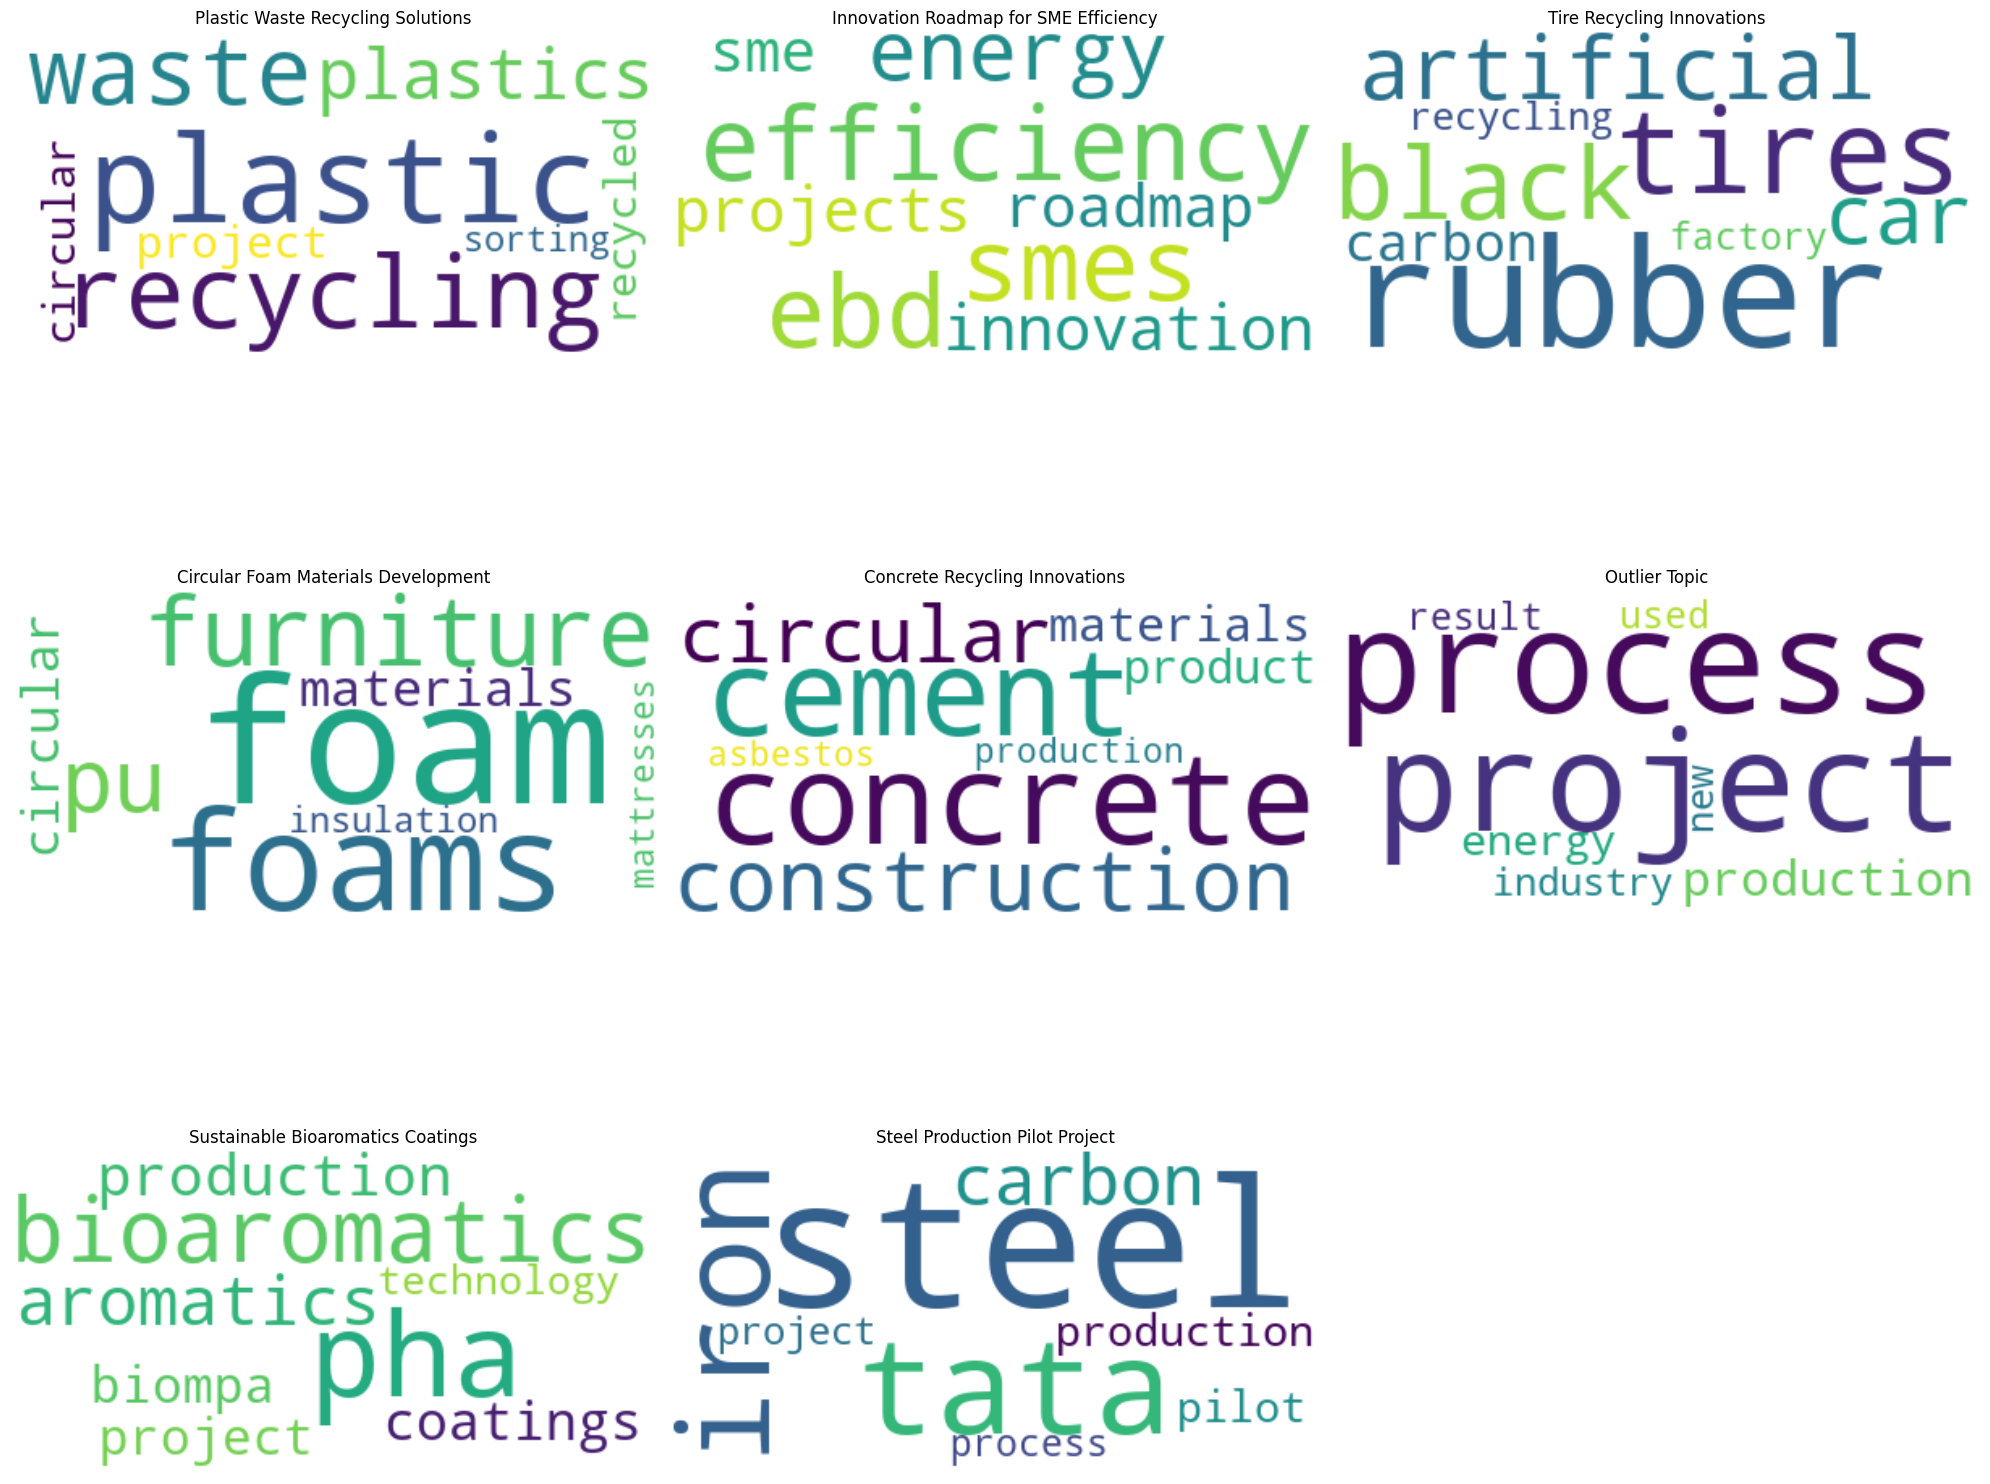

In [26]:
def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    return wc.generate_from_frequencies(text)

# generate and plot each word cloud
cols = 3 
rows = (len(TOPICS) + cols - 1) // cols
plt.figure(figsize=(20, 6 * rows))

for index, topic in enumerate(TOPICS):
    plt.subplot(rows, cols, index + 1) 
    wc = create_wordcloud(topic_model, topic=topic)
    
    # retrieve the custom name for the topic
    topic_projects = df_projects[df_projects['Topic'] == topic]
    if not topic_projects.empty:
        title = topic_projects['CustomName'].iloc[0]
    else:
        title = f"Topic {topic}"
    
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()
plt.show()

## **VIZUALIZATIONS FOR ONE SPECIFIC TOPIC** <a class="anchor" id="visual_one"></a>

How to use: Choose a single topic you want to visualize, pick one number from the topics that where assigned to your query. By default this will be the topic that best matched your query. The topics found are listed here again below:

In [27]:
print_markdown("### Topics, ranked top to bottom, match with query:\n")
topics_list = []
for i in TOPICS:
    if i >= 0:
        topic_projects = df_projects[df_projects['Topic'] == i]
        if not topic_projects.empty:
            topics_list.append(f"({i}): {topic_projects['CustomName'].iloc[0]}")

print_markdown_list(topics_list)

### Topics, ranked top to bottom, match with query:


- ##### (0): Plastic Waste Recycling Solutions
- ##### (15): Innovation Roadmap for SME Efficiency
- ##### (12): Tire Recycling Innovations
- ##### (10): Circular Foam Materials Development
- ##### (8): Concrete Recycling Innovations
- ##### (11): Sustainable Bioaromatics Coatings
- ##### (6): Steel Production Pilot Project


##### <font color='red'>**SELECT**</font><br>

In [28]:
SELECTED_TOPIC_ID = TOPICS[0] # choose topic for visualizations, default is best match with query (the top one). Example input: 35

In [29]:
TOPIC_INDEX = SELECTED_TOPIC_ID + 1
SELECTED_TOPIC_NAME = topic_model.get_topic_info()['CustomName'][TOPIC_INDEX]
print_markdown(f'### Selected topic is: ({SELECTED_TOPIC_ID}): {SELECTED_TOPIC_NAME}')

### Selected topic is: (0): Plastic Waste Recycling Solutions

#### **PROJECTS IN TOPIC** <a class="anchor" id="projects_topic"></a>

##### <font color='red'>**PARAMETER**</font>

In [30]:
THRESHOLD_DOC_PROB_TABLE = 0.1  # adjust the threshold based on your needs, docs below the trehshold will not be shown

In [31]:
topic_name = topic_model.get_topic_info()['CustomName'][TOPIC_INDEX]
print_markdown(f'### This table shows the likelihood that projects belong to Topic ({SELECTED_TOPIC_ID}) {SELECTED_TOPIC_NAME}:')

# extract the probabilities for the specific topic
if LOAD_MODEL:
    specific_topic_probs = probs[:, TOPIC_INDEX]
else:
    specific_topic_probs = probs[:, SELECTED_TOPIC_ID]

# find documents with a probability above the threshold
doc_indices = np.where(specific_topic_probs >= THRESHOLD_DOC_PROB_TABLE)[0]

docs_with_specific_topic = [docs[i] for i in doc_indices]

df_specific_topic = pd.DataFrame({
    'document': docs_with_specific_topic,
    'probability': specific_topic_probs[doc_indices]
})

# sort the dataframe in descending order
df_specific_topic = df_specific_topic.sort_values(by='probability', ascending=False).reset_index(drop=True)

df_specific_topic['probability'] = df_specific_topic['probability'].round(2)

# nicer dataframe displays
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None) 
pd.set_option('display.max_colwidth', 500)

display(df_specific_topic.head(5))

# create dataframe with only top 10 documents
df_specific_topic_top_n = df_specific_topic.head(10)

# truncate documents to threshold
df_specific_topic_top_n['document'] = df_specific_topic_top_n['document'].str.slice(0, 100)

fig = go.Figure(go.Bar(
    x=df_specific_topic_top_n['probability'],
    y=df_specific_topic_top_n.index,
    text=df_specific_topic_top_n['document'],
    textposition='auto',
    orientation='h',
    marker_color='skyblue'
))

fig.update_layout(
    title_text=f'Projects sorted on probability for Topic {SELECTED_TOPIC_ID} ({SELECTED_TOPIC_NAME})',
    xaxis_title=f'Probability of matching to topic {SELECTED_TOPIC_ID}',
    yaxis_title='Projects',
    autosize=False,
    width=800,
    height=400,
    margin=dict(l=50, r=50, b=100, t=100, pad=4)
)

fig.update_yaxes(autorange="reversed")

fig.show()

### This table shows the likelihood that projects belong to Topic (0) Plastic Waste Recycling Solutions:

,document,probability
0,prezero reason dutch households throw away hundreds of thousands of tons of plastic packaging beverage cartons and metal packaging every year also known as pmd since january municipalities are obliged to collect this packaging waste and have it separated this separation often takes place at industrial sorters that separate the pmd material into various fractions namely mono streams and residual waste the mono streams can be recycled and thus form raw material for new items plastic that can n...,0.87
1,plastic to chemicals kampen aanleiding plastic waste is a rapidly increasing problem in our modern world although many techniques exist to recycle plastic waste still a large amount of plastics end up in incineration plants in dump sites and even in nature the majority of the plastic waste that is recycled is recycled mechanically however mechanical recycling has its limitations as it results in downcycling leading to the quality of the recyclate getting lower and lower besides the quality i...,0.86
2,towards improved circularity of polyolefinbased packaging aanleiding in order to get full circularity of plastics both mechanical and chemical recycling needs to be applied but based on the current knowledge it is not possible to make this economically feasible plastic waste is the feedstock for circularity and the quality of the feedstock as well as of recycled products is crucial for market acceptance and economical as well as ecological success of the currently in the netherlands produced...,0.84
3,demonstration of an innovative system for recycling absorbent hygiene products rahp to plastics aanleiding in the netherlands approximately kton of postconsumer absorbent hygiene products ahp is incinerated every year the main reasons for a lack of substantial recycling solutions with concern to postconsumer ahpmaterial are the complex composition of the material in combination with the presence of pollutants such as drug residues and pathogens as a direct consequence of incineration the cur...,0.84
4,polymer valley reason the netherlands and europe want to move towards a circular economy reuse and recycling are indispensable for this the essence of raw materials is not discarded after use but given a new life prezero also shares this ambition and has therefore installed the most modern sorting facility in the netherlands in zwolle however they see a problem has arisen in the world and also within their organization with plastic waste fractions mpoflex and ldpe these fractions are process...,0.84


##### <font color='red'>**SELECT**</font><br>

In [32]:
# SELECTED_PROJECT_ID refers to the IDs shown in the figure above which is based relative to your selected topic (this is not the original project ID)
SELECTED_PROJECT_ID = 0

In [33]:
document_text = df_specific_topic['document'][SELECTED_PROJECT_ID]

document_text = textwrap.fill(document_text, width=200)
print_markdown(document_text)

prezero reason dutch households throw away hundreds of thousands of tons of plastic packaging beverage cartons and metal packaging every year also known as pmd since january municipalities are obliged
to collect this packaging waste and have it separated this separation often takes place at industrial sorters that separate the pmd material into various fractions namely mono streams and residual
waste the mono streams can be recycled and thus form raw material for new items plastic that can no longer be recycled the residual waste is used as fuel for power stations and cement kilns various
lca studies agree that mechanical recycling of plastic yields the greatest environmental benefit plastics are therefore very suitable for remaining high in the technical circular chain for as long as
possible instead of converting them into energy or dumping them after use on the one hand this saves significant amounts of coemissions on the other hand the production of plastic recyclate is many
times more energyfriendly than the production of comparable new virgin material objective much of this pmd material is transported to germany to be separated there because there is insufficient
sorting capacity in the netherlands in addition a significant part is still incinerated for energy generation while a large part of usable fractions are still in it the residual waste is present the
aim of this project is to demonstrate a new technology in the netherlands with which it is possible on a full scale basis tonyear to reduce the percentage of mixed plastics by almost doubling the
number of mono streams of recyclable plastics the recycling rate increases which increases more and better new products can be produced to reduce the percentage of residual waste the portion that
still goes to the incinerator to significantly reduce the number of transport kilometers this will be demonstrated in europe the most environmentally friendly sorting installation in zwolle short
description the project will be carried out in its entirety by prezero where the following phasing is used installation process november testing december commissioning january result the result will
be the most modern pmd sorting installation industry in europe that can achieve a much higher separation efficiency than the existing installations resulting in a significant coreduction total co
reduction in year amounts to improvement in sorting efficiency reduction in transport kilometers total tonnes of co which means a subsidy value in eurotons co of tonnes

#### **RELATED TOPICS** <a class="anchor" id="topic_related"></a>

In [34]:
# topic embeddings
topic_embeddings = topic_model.topic_embeddings_
specific_topic_embedding = topic_embeddings[TOPIC_INDEX].reshape(1, -1)

# compute the cosine similarity
similarities = cosine_similarity(specific_topic_embedding, topic_embeddings).flatten()
distances = 1 - similarities
distances = np.round(distances, 2)

# sort the distances
sorted_indices = np.argsort(distances)

topic_info = topic_model.get_topic_info().loc[sorted_indices].iloc[:, :5]

topic_info.rename(columns={'Count': 'document_count'}, inplace=True)

topic_info['distance'] = distances[sorted_indices]

print_markdown(f'### This table shows a list of topics that are closest to topic {SELECTED_TOPIC_ID} using cosine similarity:')

display(topic_info.head(10))

### This table shows a list of topics that are closest to topic 0 using cosine similarity:

,Topic,document_count,Name,CustomName,Representation,distance
1,0,94,0_plastic_recycling_waste_plastics,Plastic Waste Recycling Solutions,"[plastic, recycling, waste, plastics, project, recycled, circular, sorting]",0.00
0,-1,163,-1_process_project_production_energy,Outlier Topic,"[process, project, production, energy, new, industry, result, used]",0.15
13,12,12,12_rubber_tires_black_artificial,Tire Recycling Innovations,"[rubber, tires, black, artificial, car, carbon, recycling, factory]",0.20
11,10,17,10_foam_foams_furniture_pu,Circular Foam Materials Development,"[foam, foams, furniture, pu, materials, circular, insulation, mattresses]",0.20
12,11,16,11_pha_bioaromatics_aromatics_production,Sustainable Bioaromatics Coatings,"[pha, bioaromatics, aromatics, production, coatings, biompa, project, technology]",0.21
9,8,22,8_concrete_cement_construction_circular,Concrete Recycling Innovations,"[concrete, cement, construction, circular, materials, product, production, asbestos]",0.25
17,16,9,16_metals_conmeq_ash_nonferrous,Sustainable Metal Waste Processing,"[metals, conmeq, ash, nonferrous, aluminum, wheel, melting, metal]",0.26
6,5,34,5_capture_formic_solvent_feasibility,Sustainable Formic Acid Production,"[capture, formic, solvent, feasibility, acid, technology, project, study]",0.27
5,4,36,4_water_membranes_membrane_treatment,Innovative Water Treatment Membranes,"[water, membranes, membrane, treatment, process, wastewater, project, separation]",0.29
3,2,46,2_biomass_pyrolysis_oil_wood,Advanced Pyrolysis Biofuel Projects,"[biomass, pyrolysis, oil, wood, fuel, fuels, project, use]",0.30


##### <font color='red'>**PARAMETER**</font>

In [35]:
# set minimal distance (cosine similarity) fo find closest related topics
MIN_DISTANCE = 0.3

In [36]:
# show other topics that are closest related
closest_topics = topic_info[topic_info['distance'] < MIN_DISTANCE]['Topic']
title_barchart = f'Topics with cosine distance < {MIN_DISTANCE} with Topic {SELECTED_TOPIC_ID} ({SELECTED_TOPIC_NAME})'
topic_model.visualize_barchart(title=title_barchart, topics=closest_topics, n_words=15, custom_labels=True, width=450, height=300)

## **VIZUALIZATIONS FOR MULTIPLE TOPICS** <a class="anchor" id="visual_multiple"></a>

Choose multiple topics you want to visualize, in python list format. By default this will be the all the topics. The topics matched with your query are listed here again below:

In [37]:
print_markdown("### Topics, ranked top to bottom, match with query:\n")
topics_list = []
for i in TOPICS:
    if i >= 0:
        topic_projects = df_projects[df_projects['Topic'] == i]
        if not topic_projects.empty:
            topics_list.append(f"({i}): {topic_projects['CustomName'].iloc[0]}")

print_markdown_list(topics_list)

### Topics, ranked top to bottom, match with query:


- ##### (0): Plastic Waste Recycling Solutions
- ##### (15): Innovation Roadmap for SME Efficiency
- ##### (12): Tire Recycling Innovations
- ##### (10): Circular Foam Materials Development
- ##### (8): Concrete Recycling Innovations
- ##### (11): Sustainable Bioaromatics Coatings
- ##### (6): Steel Production Pilot Project


##### <font color='red'>**SELECT**</font> AND <font color='red'>**PARAMETER**</font><br>

In [38]:
# choose your topic IDs:
SELECTED_TOPIC_IDS = TOPICS[:3]

# visualizations
START_YEAR = 2015  # start year for generating visualizations
END_YEAR = 2023  # end year for generating visualizations

In [39]:
print_markdown('### The selected topics are:')
topics_list = []
for topic_id in SELECTED_TOPIC_IDS:
    TOPIC_INDEX = topic_id + 1
    SELECTED_TOPIC_NAME = topic_model.get_topic_info()['CustomName'][TOPIC_INDEX]
    topics_list.append(f'({topic_id}): {SELECTED_TOPIC_NAME}')
    
print_markdown_list(topics_list)

### The selected topics are:

- ##### (0): Plastic Waste Recycling Solutions
- ##### (15): Innovation Roadmap for SME Efficiency
- ##### (12): Tire Recycling Innovations


#### **PROJECT COUNT OVER TIME** <a class="anchor" id="project_count"></a>

In [40]:
df_projects['start_year'] = df_projects['Looptijd'].str.extract(r'(\d{4})')
df_projects['start_date'] = df_projects['start_year'] + '-01-01'

# convert 'start_date' to datetime format
df_projects['start_date'] = pd.to_datetime(df_projects['start_date'])


# filter data
filtered_data = df_projects[(df_projects['start_date'].dt.year >= START_YEAR) &
                            (df_projects['start_date'].dt.year <= END_YEAR) &
                            (df_projects['Topic'].isin(TOPICS))]

# group data by year and topic
grouped_data = filtered_data.groupby([filtered_data['start_date'].dt.year, 'Topic'])[COLUMN_PROJECT_ID].count().unstack(fill_value=0)
all_years = pd.Index(range(START_YEAR, END_YEAR + 1), name='Year')
grouped_data = grouped_data.reindex(all_years, fill_value=0)

line_fig = go.Figure()

topic_data = filtered_data.drop_duplicates(subset=['Topic'])

for topic in SELECTED_TOPIC_IDS:
    if topic in grouped_data.columns:
        representation = topic_data.loc[topic_data['Topic'] == topic, 'CustomName'].iloc[0]
        if isinstance(representation, list):
            representation = ', '.join(representation)
        
        line_fig.add_trace(go.Scatter(
            x=grouped_data.index,
            y=grouped_data[topic],
            name=representation,
            mode='lines+markers'
        ))

line_fig.update_layout(
    title='Project Count by Topic Over Time (Line Plot)',
    xaxis_title='Year',
    yaxis_title='Number of Projects',
    legend_title='CustomName'
)

line_fig.show()

if EXPORT_GRAPHS_CSV:
    grouped_data.to_csv('graph_exports/rvo/project_count_by_topic_over_time.csv')

In [41]:
# filter data
filtered_data = df_projects[(df_projects['start_date'].dt.year >= START_YEAR) &
                            (df_projects['start_date'].dt.year <= END_YEAR) &
                            (df_projects['Topic'].isin(TOPICS))]

df_cleaned_projects = filtered_data[filtered_data['CustomName'] != 'Outlier Topic']
df_cleaned_projects = df_cleaned_projects[df_cleaned_projects['Topic'].isin(SELECTED_TOPIC_IDS)]

df_cleaned_projects['year'] = pd.to_datetime(df_cleaned_projects['start_date']).dt.year

# filter dataframe to only include top 25
top_25_topics = df_cleaned_projects['CustomName'].value_counts().head(25).index.tolist()
df_top_topics = df_cleaned_projects[df_cleaned_projects['CustomName'].isin(top_25_topics)]

# create a pivot table to count the frequency of topics per year
heatmap_data = pd.pivot_table(df_top_topics, values='Topic', index='CustomName', columns='year', aggfunc='count', fill_value=0)

# custom colors
colorscale = [[0, 'rgb(255,255,255)'], [1, 'rgba(99,110,251,255)']]

fig = go.Figure(data=go.Heatmap(
                   z=heatmap_data.values,
                   x=heatmap_data.columns,
                   y=heatmap_data.index,
                   colorscale=colorscale,
                   zmin=0, zmax=heatmap_data.values.max(),
                   text=heatmap_data.values,
                   texttemplate='%{text}',
                   textfont={"size":10}
               ))

fig.update_layout(
    title='Heatmap of Selected Topic Frequencies by Year',
    xaxis_nticks=len(heatmap_data.columns),
    yaxis_nticks=len(heatmap_data.index),
    xaxis_title="Year",
    yaxis_title="Topic"
)

fig.show()

if EXPORT_GRAPHS_CSV:
    heatmap_data.to_csv('graph_exports/rvo/heatmap_of_selected_topic_frequencies_by_year.csv')

#### **SUB-DEPARTMENTS** <a class="anchor" id="sub_departments"></a>

##### <font color='red'>**PARAMETER**</font>

In [42]:
FUNDING_COUNT_THRESHOLD = 3

In [43]:
# filter the dataframe for the specified topic IDs
filtered_topics = df_projects[df_projects['Topic'].isin(SELECTED_TOPIC_IDS)]

# sum the 'Subsidiebedrag' for each funding scheme
funding_sums = filtered_topics.groupby(COLUMN_FUNDING_SCHEME)['Subsidiebedrag'].sum().reset_index(name='Total Subsidiebedrag')

# sort the funding sums in descending order
funding_sums = funding_sums.sort_values(by='Total Subsidiebedrag', ascending=False)

funding_sums['Funding Scheme'] = funding_sums[COLUMN_FUNDING_SCHEME]

fig = go.Figure(data=[go.Bar(
    y=funding_sums['Funding Scheme'],
    x=funding_sums['Total Subsidiebedrag'],
    orientation='h'
)])

fig.update_layout(
    title=f"Funding Schemes for selected Topics:{SELECTED_TOPIC_IDS}",
    xaxis_title="Total Subsidiebedrag",
    yaxis_title="Funding Scheme",
    height=600
)

fig.show()

if EXPORT_GRAPHS_CSV:
    funding_sums.to_csv('graph_exports/rvo/total_subsidiebedrag_by_funding_scheme.csv', index=False)

#### **FUNDING SCHEMES** <a class="anchor" id="funding"></a>

In [44]:
def plot_top_n_schemes(df, column_name, start_year, end_year, top_n, max_characters, selected_topic_ids, values_to_exclude):
    # convert 'start_date' to datetime format
    df['start_date'] = pd.to_datetime(df['start_date'])
    
    # add truncated column
    truncated_column = f'truncated_{column_name}'
    df[truncated_column] = df[column_name].str[:max_characters]
    
    # filter data
    filtered_data = df[
        (df['start_date'].dt.year >= start_year) &
        (df['start_date'].dt.year <= end_year) &
        (df['Topic'].isin(selected_topic_ids)) &
        (~df[column_name].isin(values_to_exclude))
    ]
    
    # group data by year and truncated column
    grouped_data = filtered_data.groupby([filtered_data['start_date'].dt.year, truncated_column])[COLUMN_PROJECT_ID].count().unstack(fill_value=0)
    all_years = pd.Index(range(start_year, end_year + 1), name='Year')
    grouped_data = grouped_data.reindex(all_years, fill_value=0)
    
    # calculate total counts for each truncated scheme
    total_counts = grouped_data.sum(axis=0)
    
    # get the top N truncated schemes by count
    top_n_schemes = total_counts.nlargest(top_n).index
    
    # filter the grouped data to include only the top N truncated schemes
    grouped_data = grouped_data[top_n_schemes]
    
    line_fig = go.Figure()
    
    for scheme in top_n_schemes:
        if scheme in grouped_data.columns:
            line_fig.add_trace(go.Scatter(
                x=grouped_data.index,
                y=grouped_data[scheme],
                name=scheme,
                mode='lines+markers'
            ))
    
    line_fig.update_layout(
        title=f'Project Count by Top {top_n} {column_name} (Truncated to {max_characters} Characters) Over Time (Line Plot)',
        xaxis_title='Year',
        yaxis_title='Number of Projects',
        legend_title=column_name
    )
    
    line_fig.show()
    
    safe_column_name = column_name.replace('/', '_').replace('\\', '_')
    if EXPORT_GRAPHS_CSV:
        grouped_data.to_csv(f'graph_exports/rvo/project_count_by_top_{top_n}_{safe_column_name}_over_time.csv')


plot_top_n_schemes(
    df=df_projects,
    column_name=COLUMN_FUNDING_SCHEME,
    start_year=START_YEAR,
    end_year=END_YEAR,
    top_n=7,
    max_characters=4, # truncate funding scheme names to get data grouped on a relevant level
    selected_topic_ids=SELECTED_TOPIC_IDS,
    values_to_exclude=[]
)


plot_top_n_schemes(
    df=df_projects,
    column_name='TKI/Thema',
    start_year=START_YEAR,
    end_year=END_YEAR,
    top_n=5,
    max_characters=50,
    selected_topic_ids=SELECTED_TOPIC_IDS,
    values_to_exclude=[]
)


plot_top_n_schemes(
    df=df_projects,
    column_name='Innovatiethema(\'s)',
    start_year=START_YEAR,
    end_year=END_YEAR,
    top_n=5,
    max_characters=50,
    selected_topic_ids=SELECTED_TOPIC_IDS,
    values_to_exclude=[]
)

plot_top_n_schemes(
    df=df_projects,
    column_name='Penvoerder',
    start_year=START_YEAR,
    end_year=END_YEAR,
    top_n=5,
    max_characters=50,
    selected_topic_ids=SELECTED_TOPIC_IDS,
    values_to_exclude=['']  # remove empty values
)

In [45]:
def plot_top_n_schemes(df, column_name, start_year, end_year, top_n, max_characters, selected_topic_ids, values_to_exclude):
    # convert 'start_date' to datetime format
    df['start_date'] = pd.to_datetime(df['start_date'])
    
    # add truncated column
    truncated_column = f'truncated_{column_name}'
    df[truncated_column] = df[column_name].str[:max_characters]
    
    # filter data
    filtered_data = df[
        (df['start_date'].dt.year >= start_year) &
        (df['start_date'].dt.year <= end_year) &
        (df['Topic'].isin(selected_topic_ids)) &
        (~df[column_name].isin(values_to_exclude))
    ]
    
    # group data by year and truncated column
    grouped_data = filtered_data.groupby([filtered_data['start_date'].dt.year, truncated_column])['Subsidiebedrag'].sum().unstack(fill_value=0)
    all_years = pd.Index(range(start_year, end_year + 1), name='Year')
    grouped_data = grouped_data.reindex(all_years, fill_value=0)
    
    # calculate total counts for each truncated scheme
    total_counts = grouped_data.sum(axis=0)
    
    # get the top N truncated schemes by count
    top_n_schemes = total_counts.nlargest(top_n).index
    
    # filter the grouped data to include only the top N truncated schemes
    grouped_data = grouped_data[top_n_schemes]
    
    line_fig = go.Figure()
    
    for scheme in top_n_schemes:
        if scheme in grouped_data.columns:
            line_fig.add_trace(go.Scatter(
                x=grouped_data.index,
                y=grouped_data[scheme],
                name=scheme,
                mode='lines+markers'
            ))
    
    line_fig.update_layout(
        title=f'Sum of Subsidiebedrag by Top {top_n} {column_name} (Truncated to {max_characters} Characters) Over Time (Line Plot)',
        xaxis_title='Year',
        yaxis_title='Sum of Subsidiebedrag',
        legend_title=column_name
    )
    
    line_fig.show()
    
    safe_column_name = column_name.replace('/', '_').replace('\\', '_')
    if EXPORT_GRAPHS_CSV:
        grouped_data.to_csv(f'graph_exports/rvo/sum_of_subsidiebedrag_by_top_{top_n}_{safe_column_name}_over_time.csv')


plot_top_n_schemes(
    df=df_projects,
    column_name=COLUMN_FUNDING_SCHEME,
    start_year=START_YEAR,
    end_year=END_YEAR,
    top_n=7,
    max_characters=4, # truncate funding scheme names to get data grouped on a relevant level
    selected_topic_ids=SELECTED_TOPIC_IDS,
    values_to_exclude=[]
)


plot_top_n_schemes(
    df=df_projects,
    column_name='TKI/Thema',
    start_year=START_YEAR,
    end_year=END_YEAR,
    top_n=5,
    max_characters=50,
    selected_topic_ids=SELECTED_TOPIC_IDS,
    values_to_exclude=[]
)


plot_top_n_schemes(
    df=df_projects,
    column_name='Innovatiethema(\'s)',
    start_year=START_YEAR,
    end_year=END_YEAR,
    top_n=5,
    max_characters=50,
    selected_topic_ids=SELECTED_TOPIC_IDS,
    values_to_exclude=[]
)

plot_top_n_schemes(
    df=df_projects,
    column_name='Penvoerder',
    start_year=START_YEAR,
    end_year=END_YEAR,
    top_n=5,
    max_characters=50,
    selected_topic_ids=SELECTED_TOPIC_IDS,
    values_to_exclude=['']  # remove empty values
)

#### **FUNDING SCHEMES IN DEPTH** <a class="anchor" id="funding_whole"></a>

##### <font color='red'>**PARAMETER**</font>

In [46]:
MAX_CHARACTERS_FUNDING = 4 # truncate the names of the funding schemes to n characters

In [47]:
# filter the dataframe for the specified topic IDs
filtered_topics = df_projects[df_projects['Topic'].isin(SELECTED_TOPIC_IDS)]

#  step 1: truncate funding scheme names
filtered_topics = filtered_topics[filtered_topics[COLUMN_FUNDING_SCHEME] != 'Outlier Topic']
filtered_topics['funding_scheme_truncated'] = filtered_topics[COLUMN_FUNDING_SCHEME].str.slice(0, MAX_CHARACTERS_FUNDING)

# step 1: identify the top 12 funding schemes
TOP_N_FUNDINGSCHEMES = 12
top_funding_schemes = filtered_topics.groupby('funding_scheme_truncated')['Subsidiebedrag'].sum().nlargest(TOP_N_FUNDINGSCHEMES).index.tolist()

# step 2: create a subplot grid with 6 rows and 2 columns
fig = make_subplots(rows=6, cols=2, subplot_titles=top_funding_schemes)

# map topics to their representative words
topic_labels = {topic: ''.join(words) for topic, words in topic_model.get_topic_info().set_index('Topic')['CustomName'].to_dict().items()}

# function to create a bar chart for a given funding scheme
def add_bar_chart(fig, funding_scheme, row, col):
    # filter the topic_counts dataframe for the specified funding_scheme
    filtered_topic_counts = filtered_topics[filtered_topics['funding_scheme_truncated'] == funding_scheme]

    # sum the 'Subsidiebedrag' for each topic within the specified funding_scheme
    topic_sums = filtered_topic_counts.groupby('Topic')['Subsidiebedrag'].sum().reset_index()
    topic_sums.columns = ['Topic', 'Total_Subidy']

    # sort values by total subsidy amount
    topic_sums = topic_sums.sort_values(by='Total_Subidy', ascending=True)

    fig.add_trace(go.Bar(
        y=[topic_labels[topic] for topic in topic_sums['Topic']],
        x=topic_sums['Total_Subidy'],
        orientation='h'
    ), row=row, col=col)

# step 3: iterate over the top funding schemes and add a bar chart for each
for idx, funding_scheme in enumerate(top_funding_schemes):
    row = (idx // 2) + 1
    col = (idx % 2) + 1
    add_bar_chart(fig, funding_scheme, row, col)

fig.update_layout(
    height=1800,  # adjust height to fit 6 rows
    title_text="Topics for Top 12 Funding Schemes Based on Total Subsidy Amount",
    showlegend=False  # hide the legend to avoid clutter
)

fig.show()

##### <font color='red'>**PARAMETER**</font>

In [48]:
MAX_CHARACTERS = 4 # truncate the name of the funding schemes to n characters
TOP_N_FUNDINGSCHEMES = 12 # select the n top funding schemes in the dataset

In [49]:
# filter the dataframe for the specified topic IDs
filtered_topics = df_projects[df_projects['Topic'].isin(SELECTED_TOPIC_IDS)]

# remove topics with custom name 'Outlier Topic'
df_cleaned_projects = filtered_topics[filtered_topics['CustomName'] != 'Outlier Topic']

# truncate funding scheme names
df_cleaned_projects['funding_scheme_truncated'] = df_cleaned_projects[COLUMN_FUNDING_SCHEME].str.slice(0, MAX_CHARACTERS)

# find the top funding schemes
top_funding_schemes = df_cleaned_projects['funding_scheme_truncated'].value_counts().head(TOP_N_FUNDINGSCHEMES).index.tolist()

# filter datafarme to only include top funding schemes
df_top_funding_schemes = df_cleaned_projects[df_cleaned_projects['funding_scheme_truncated'].isin(top_funding_schemes)]

# find the top 25 topics by frequency
top_25_topics = df_top_funding_schemes['CustomName'].value_counts().head(25).index.tolist()

# filter dataframe to only include top 25 topics
df_top_topics = df_top_funding_schemes[df_top_funding_schemes['CustomName'].isin(top_25_topics)]

# create a pivot table to sum 'Subsidiebedrag' for each topic per funding scheme
heatmap_data = pd.pivot_table(df_top_topics, values='Subsidiebedrag', index='CustomName', columns='funding_scheme_truncated', aggfunc='sum', fill_value=0)

# custom colors
colorscale = [[0, 'rgb(255,255,255)'], [1, 'rgba(99,110,251,255)']]

# print values as millions
heatmap_data_millions = heatmap_data / 1e6
text_values = np.round(heatmap_data_millions.values, 1)

fig = go.Figure(data=go.Heatmap(
                   z=heatmap_data.values,
                   x=heatmap_data.columns,
                   y=heatmap_data.index,
                   colorscale=colorscale,
                   text=text_values,
                   texttemplate='%{text}M',
                   textfont={"size":10},
))

fig.update_layout(
    title="Heatmap of Topic Frequencies by Top Funding Revenue",
    xaxis_title="Funding Scheme",
    yaxis_title="Topic",
)

fig.show()

if EXPORT_GRAPHS_CSV:
    heatmap_data.to_csv('graph_exports/rvo/heatmap_of_topic_frequencies_by_top_funding_revenue.csv', index=False)

## **DEEP DIVE INTO TOPIC** <a class="anchor" id="deep_dive"></a>

Run the topic analysis again on a specific topic, this will analyse all the projects in that topic and make new sub-topics. Choose a topic number from the previous acuired list, for convienve the topics are listed here again:

In [50]:
print_markdown("### Topics, ranked top to bottom, match with query:\n")
topics_list = []
for i in TOPICS:
    if i >= 0:
        topic_projects = df_projects[df_projects['Topic'] == i]
        if not topic_projects.empty:
            topics_list.append(f"({i}): {topic_projects['CustomName'].iloc[0]}")

print_markdown_list(topics_list)

### Topics, ranked top to bottom, match with query:


- ##### (0): Plastic Waste Recycling Solutions
- ##### (15): Innovation Roadmap for SME Efficiency
- ##### (12): Tire Recycling Innovations
- ##### (10): Circular Foam Materials Development
- ##### (8): Concrete Recycling Innovations
- ##### (11): Sustainable Bioaromatics Coatings
- ##### (6): Steel Production Pilot Project


##### <font color='red'>**SELECT**</font><br>

In [51]:
TOPICS_ZOOM = TOPICS[:1] # choose topic number, by default it is best match. e.g.: TOPCIS_ZOOM = [28]

##### <font color='red'>**PARAMETER**</font>

In [52]:
# the number of words per topic that you want to be extracted. These words are most representative of the topic. Should be kept between 10-20.
N_WORDS_REPRESENTATION_ZOOM = 8
# the number of words you want in your topic representation. If you want 'Circular Economy' in your representations, set it to (1,2)
N_GRAM_RANGE_ZOOM = (1, 2)
# the minimum size of a topic. Lower means more topics, higher means less topics. This should be lower now because we are searching within a topic, which has a lot less projects.
MIN_TOPIC_SIZE_ZOOM = 4

In [53]:
df_projects_zoom = df_projects[df_projects['Topic'].isin(TOPICS_ZOOM)]
print(f'Data shape: {df_projects_zoom.shape}')
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 40)
display(df_projects_zoom.head(1))

docs_zoom = list(df_projects_zoom.text.values) # create stacked list of abstracts
embeddings_zoom = sentence_model.encode(docs_zoom, show_progress_bar=True)

vectorizer_model = CountVectorizer(stop_words="english")

topic_model_zoom = BERTopic(verbose=True, 
                    calculate_probabilities=True,
                    top_n_words=N_WORDS_REPRESENTATION_ZOOM,
                    n_gram_range=N_GRAM_RANGE_ZOOM,
                    min_topic_size=MIN_TOPIC_SIZE_ZOOM,
                    vectorizer_model=vectorizer_model,
                    representation_model=representation_model,
                    embedding_model=sentence_model)

topics_zoom, probs_zoom = topic_model_zoom.fit_transform(docs_zoom, embeddings_zoom)

# add chatgpt labels to the model
chatgpt_topic_labels_zoom = {topics_zoom: " | ".join(list(zip(*values))[0]) for topics_zoom, values in topic_model_zoom.topic_aspects_["OpenAI"].items()}
chatgpt_topic_labels_zoom[-1] = "Outlier Topic"
topic_model_zoom.set_topic_labels(chatgpt_topic_labels_zoom)

df_topic_info_zoom = topic_model_zoom.get_topic_info()

display(topic_model_zoom.get_topic_info().head(2))
display(topic_model_zoom.visualize_barchart(top_n_topics=8, n_words=10, custom_labels=True, width=400))

Data shape: (102, 23)


,Subsidie categorie,TKI/Thema,Innovatiethema('s),Subsidieregeling,Projectnummer,Looptijd,Subsidiebedrag,Penvoerder,Projectconsortium,Projecttitel,Publieke samenvatting,Website link,text,language,Topic,Representation,CustomName,start_year,start_date,truncated_Subsidie categorie,truncated_TKI/Thema,truncated_Innovatiethema('s),truncated_Penvoerder
18,MOOI-regeling,6. Circulair,Circulaire kunststoffen,TSE-20-22-04 - MOOI Industrie,MOOI42013,30-06-2021 - 30-06-2025,3434469.0,Stichting Dutch Polymer Institute,Avery Dennison Materials Europe B.V....,an integrated approach towards recyc...,aanleiding plastics significantly co...,https://projecten.topsectorenergie.n...,an integrated approach towards recyc...,en,0,"[plastic, recycling, waste, plastics...",Plastic Waste Recycling Solutions,2021,2021-01-01,MOOI,6. Circulair,Circulaire kunststoffen,Stichting Dutch Polymer Institute


Batches: 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]
2024-06-29 09:32:08,636 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-29 09:32:09,825 - BERTopic - Dimensionality - Completed ✓
2024-06-29 09:32:09,825 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-29 09:32:09,833 - BERTopic - Cluster - Completed ✓
2024-06-29 09:32:09,835 - BERTopic - Representation - Extracting topics from clusters using representation models.
  0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 8/8 [00:06<00:00,  1.17it/s]
2024-06-29 09:32:16,763 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,CustomName,Representation,OpenAI,Representative_Docs
0,-1,35,-1_plastic_waste_recycling_project,Outlier Topic,"[plastic, waste, recycling, project,...",[Advanced Plastic Recycling Technolo...,[catalystassisted chemical delaminat...
1,0,17,0_waste_project_sorting_recycling,Diaper Recycling Innovation,"[waste, project, sorting, recycling,...",[Diaper Recycling Innovation],[feasibility study of diaper recycli...


## **SOURCES** <a class="anchor" id="sources"></a>
<ol>
  <li>Grootendorst, M. (n.d.). <em>Topics per class using BERTopic</em>. Retrieved from <a href="https://towardsdatascience.com/topics-per-class-using-bertopic-252314f2640">https://towardsdatascience.com/topics-per-class-using-bertopic-252314f2640</a></li>
  <li>Grootendorst, M. (n.d.). <em>Parameter Tuning</em>. BERTopic. Retrieved from <a href="https://maartengr.github.io/BERTopic/getting_started/parameter%20tuning/parametertuning.html">https://maartengr.github.io/BERTopic/getting_started/parameter%20tuning/parametertuning.html</a></li>
  <li>Anonymous. (n.d.). <em>OpenAI Integration</em>. Google Colab. Retrieved from <a href="https://colab.research.google.com/drive/1BoQ_vakEVtojsd2x_U6-_x52OOuqruj2?usp=sharing#scrollTo=q9kRc7MD-XMD">https://colab.research.google.com/drive/1BoQ_vakEVtojsd2x_U6-_x52OOuqruj2?usp=sharing#scrollTo=q9kRc7MD-XMD</a></li>
</ol>
